> # Word Embedding - Word2vec

> ## Descripción 

Resumen de los parametros:

* **min_count**: int - Palabras con frecuencia total en el corpus menor a la indicada según min_count, se eliminan antes de entrenar el modelo. En base a las palabras sobrevivientes se calculan las ventanas según window. De esta forma se elimina el ruido, se consideran palabras importates y se tiene un mejor resultado en general. - (2, 100)
* **window**: int - La distancia maxima entre la palabra actual y predicha dentro de una oración. Ventanas cortan tienden a relacionar palabras semánticamente similares mientras que ventanas mas grandes palabras relacionadas por tópicos. Segun un paper de 2014 por Levy and Goldberg, una ventana de tamaño 5 suele ser un buen punto de partida para los topicos mas comunes - (2, 10)
* **size**: int - Dimension del vector de embedding. Su valor depende del tamaño del corpus, por ejemplo, si se tiene un corpus de 30 palabras y se utilizan vectores de tamaño 50 esta garantizado que se realizara overfitting. A partir de diez mil palabras se puede considerar utilizar size=100 - (50, 300)
* **sample**:  float - Se trata del umbral para configurar que palabras con frecuencias altas serán remuestreadas de forma aleatoria. - (0, 1e-5)
* **negative**: int - En caso de ser mayor a cero se realizara muestreo negativo. El int definido especifica cuantas "palabras ruido" se eliminaran. - (5, 20)
* **ns_exponent**: (float, optional) – es el exponente utilizado para darle forma a la distribucion de muestreo negativa. Si es 1 entonces es igual a las frecuencias, si es 0 entonces muestrea todas las palabras de forma equitativa. El valor por defecto mas usado es 0,75 y fue el elegido en el paper original de World2Vec.

Fuente:

1. https://web.stanford.edu/~jurafsky/slp3/6.pdf
2. http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/, http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
3. https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

> ## 1) Obtencion de datos

La idea principal consiste en descargar 50.000 noticias de Eikon, para esto es necesario activar la API y crear una funcion que permita descargar las notas. Luego se entrenaran dos modelos, uno con ventana pequeña y otro con una ventana grande.

In [ ]:
import eikon as ek
from datetime import timedelta
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
import pickle

Activamos la API

In [ ]:
with open("API_KEY.txt") as f:
    API_KEY = f.read()

ek.set_app_key(API_KEY)

Función que baja los títulos de notas que traten sobre una acción (para referirnos a una acción utilizamos el RIC code)

In [ ]:
def get_news_ids(RIC_name, to_download):
    res = []
    n_news = 0
    first_loop = True
    while n_news < to_download:
        if first_loop == True:
            headlines = ek.get_news_headlines(f"R:{RIC_name}.O IN ENGLISH", 100)
            first_loop = False
        else:
            headlines = ek.get_news_headlines(f"R:{RIC_name}.O IN ENGLISH", 100, date_to = last_dt)
        headlines = headlines.sort_values("versionCreated", ascending=False)
        last_dt = headlines.iloc[-1,:]["versionCreated"]
        last_dt = last_dt - timedelta(seconds=1)
        last_dt = last_dt.strftime("%Y-%m-%dT%H:%M:%S")
        res.append(headlines)
        n_news += headlines.shape[0]

    return pd.concat(res).head(to_download)

Bajamos 500 títulos de notas (en este caso, de Microsoft)

In [ ]:
news_ids = get_news_ids("MSFT", 500)

Declaramos una función que baje los contenidos de las notas identificadas en el paso anterior

In [ ]:
def get_stories_from_ids(news_ids):
    res = []
    for _, row in tqdm(news_ids.iterrows(), total=news_ids.shape[0]):
        story = ek.get_news_story(row["storyId"])
        soup = BeautifulSoup(story, "lxml")
        res.append(soup.get_text(separator=' ').lower())
    return res

Declaramos las acciones de las cuales vamos a obtener las noticias y cuantas de cada una.

In [ ]:
stories_tickers = ["MSFT", "AAPL", "AMZN", "TSLA", "NFLX", "MELI", "NVDA", "AAL", "META", "GOOG"]
stories_count = 1000

Bajamos las notas y las guardamos en un archivo pickle. Para no perder el progreso guardaremos el de cada accion por separado.

In [ ]:
stories=[]

for ticker in stories_tickers:
    news_ids = get_news_ids(ticker, stories_count)
    stories.append(get_stories_from_ids(news_ids))
    
    with open(str(ticker) + ".p", "wb") as f:
        pickle.dump(stories, f)

> ## 2) Scraping de noticias

Las acciones analizadas fueron:
* Microsoft
* Apple
* Amazon
* Tesla
* Netflix
* Mercado Libre
* American airlines
* Meta (facebook)
* Google

El resultado del scrapping se encuentra en el archivo "*stories_download.p*"

In [1]:
import os
import re
import random
import tqdm
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import pickle
from collections import Counter
import numpy as np
import logging  # Setting up the loggings to monitor gensim
import gensim
import nltk

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s",
                    datefmt= '%H:%M:%S', level=logging.INFO)

> ### Tockenizacion
A continuación se introducen funciones para cargar, tockenizar y crear listas con las noticias descargadas.

In [6]:
file = "stories_download.p"

def load_corpus(file):
    with open(file, encoding="ISO 8859-1") as f:
        raw_text = f.read()
    yield(raw_text)


def tokenize(raw_text):
    
    sentences = sent_tokenize(raw_text)
    sentences = [word_tokenize(e) for e in sentences]
    sentences = [[e2 for e2 in e1 if re.compile("[A-Za-z]").search(e2[0])] for e1 in sentences]
    sentences = [[e2.lower() for e2 in e1] for e1 in sentences]

    return(sentences)


def gen_sentences(file, size=None, print_every=100):
    
    sentences = []
    for i, art in tqdm.tqdm(enumerate(load_corpus(file))):
        sentences.extend(tokenize(art))
        if size and i == size:
            break
    return(sentences)

In [3]:
RECALCULATE_SENTENCES = False

if RECALCULATE_SENTENCES:

    sentences = gen_sentences(file)

    with open("stories_download_token.p", "wb") as f:
        pickle.dump(sentences, f)

else:
    
    with open("stories_download_token.p", "rb") as f:
        sentences = pickle.load(f)

1it [00:39, 39.22s/it]


Como resultado se obtiene la lista de listas "sentences". La misma contiene las distintas oraciones del corpus divididas en listas. Y, dentro de cada oracion, una lista con cada palabra ya tockenizada. A continuacion se muestra la oración 140 para tomar como ejemplo:

In [87]:
sentences[139]

['this',
 'would',
 'involve',
 'an',
 'independent',
 'panel',
 'scrutinizing',
 'the',
 'deal',
 'and',
 'evaluating',
 'the',
 'results',
 'of',
 'reduced',
 'competition',
 'in',
 'the',
 'market']

> ## 3) Ventana chica
Una vez terminado el preprocesamiento, se entrena el modelo de word2vec. Si se considera 5 un numero estandar para el hiperparametro window, es logico considerar 4 como una ventana chica y 8 como una ventana grande. Se esperaria encontrar relaciones mas semanticas que por topicos entre las palabras.

In [20]:
RETRAIN_W2VEC = False

if RETRAIN_W2VEC:

    # Defino los parámetros del modelo
    model = gensim.models.Word2Vec(vector_size=50,
                                   window=4,
                                   min_count=5,
                                   negative=5,
                                   sample=0.01,
                                   workers=4,
                                   sg=1)
    
    # Se hace una pasada por el corpus y se crea el vocabulario
    model.build_vocab(sentences,
                      progress_per=10000)
    
    # Se entrena el modelo
    model.train(sentences,
                total_examples=model.corpus_count,
                epochs=20, report_delay=1)
    
    # Se guarda en disco el modelo
    model.save("ventana_chica_w2c.model")

else:
    # Se carga el modelo entrenado
    model = gensim.models.Word2Vec.load("ventana_chica_w2c.model")

INFO - 21:48:24: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=50, alpha=0.025>', 'datetime': '2022-09-03T21:48:24.040670', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}
INFO - 21:48:24: collecting all words and their counts
INFO - 21:48:24: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 21:48:24: PROGRESS: at sentence #10000, processed 291163 words, keeping 14864 word types
INFO - 21:48:24: PROGRESS: at sentence #20000, processed 567974 words, keeping 23516 word types
INFO - 21:48:24: PROGRESS: at sentence #30000, processed 860450 words, keeping 28457 word types
INFO - 21:48:24: PROGRESS: at sentence #40000, processed 1141525 words, keeping 28457 word types
INFO - 21:48:24: PROGRESS: at sentence #50000, processed 1427554 words, keeping 30915 word types
INFO - 21:48:24: PROGRESS: at sentence #60000, processed 1725487 words, kee

INFO - 21:49:02: EPOCH 5 - PROGRESS: at 99.28% examples, 785142 words/s, in_qsize 3, out_qsize 1
INFO - 21:49:02: EPOCH 5: training on 4922647 raw words (4769566 effective words) took 6.1s, 787034 effective words/s
INFO - 21:49:03: EPOCH 6 - PROGRESS: at 15.41% examples, 757900 words/s, in_qsize 7, out_qsize 0
INFO - 21:49:04: EPOCH 6 - PROGRESS: at 31.34% examples, 773209 words/s, in_qsize 7, out_qsize 0
INFO - 21:49:05: EPOCH 6 - PROGRESS: at 48.86% examples, 774265 words/s, in_qsize 7, out_qsize 0
INFO - 21:49:06: EPOCH 6 - PROGRESS: at 65.69% examples, 779182 words/s, in_qsize 7, out_qsize 0
INFO - 21:49:07: EPOCH 6 - PROGRESS: at 83.11% examples, 783590 words/s, in_qsize 7, out_qsize 0
INFO - 21:49:08: EPOCH 6 - PROGRESS: at 98.36% examples, 780721 words/s, in_qsize 7, out_qsize 0
INFO - 21:49:08: EPOCH 6: training on 4922647 raw words (4769798 effective words) took 6.1s, 784200 effective words/s
INFO - 21:49:09: EPOCH 7 - PROGRESS: at 15.03% examples, 743971 words/s, in_qsize 7, 

INFO - 21:50:15: EPOCH 17 - PROGRESS: at 65.96% examples, 777454 words/s, in_qsize 7, out_qsize 0
INFO - 21:50:16: EPOCH 17 - PROGRESS: at 83.31% examples, 781002 words/s, in_qsize 7, out_qsize 0
INFO - 21:50:17: EPOCH 17 - PROGRESS: at 99.08% examples, 780338 words/s, in_qsize 4, out_qsize 0
INFO - 21:50:18: EPOCH 17: training on 4922647 raw words (4769318 effective words) took 6.1s, 782761 effective words/s
INFO - 21:50:19: EPOCH 18 - PROGRESS: at 15.41% examples, 759352 words/s, in_qsize 7, out_qsize 0
INFO - 21:50:20: EPOCH 18 - PROGRESS: at 31.15% examples, 768636 words/s, in_qsize 7, out_qsize 0
INFO - 21:50:21: EPOCH 18 - PROGRESS: at 49.21% examples, 776917 words/s, in_qsize 7, out_qsize 0
INFO - 21:50:22: EPOCH 18 - PROGRESS: at 66.20% examples, 779505 words/s, in_qsize 7, out_qsize 0
INFO - 21:50:23: EPOCH 18 - PROGRESS: at 83.31% examples, 781798 words/s, in_qsize 7, out_qsize 0
INFO - 21:50:24: EPOCH 18 - PROGRESS: at 99.28% examples, 783796 words/s, in_qsize 3, out_qsize 1

> ### Analisis de los resultados
Una vez entrenado el modelo podemos observar los **embeddings** para cada palabra, por ejemplo para google.Como era de esperar, en base al hiperparametro vector_size tendra dimension igual a 50.

In [33]:
model.wv.get_vector("google", norm=True)

array([-0.0532142 , -0.07871234,  0.0693583 , -0.30957696,  0.05878156,
       -0.29807177,  0.05301813,  0.10450284,  0.12538286, -0.00487011,
       -0.08582536, -0.39081836,  0.19080913,  0.080897  ,  0.01383143,
        0.16384098,  0.3203923 ,  0.05672909, -0.17769219, -0.01879799,
        0.20885012, -0.01704394,  0.03002963,  0.11621373,  0.01226484,
       -0.10402951,  0.11603099,  0.0145383 , -0.02715756,  0.08803587,
       -0.268764  , -0.01448755,  0.12115871, -0.07914454, -0.17062147,
        0.05623247,  0.31357616,  0.04585413, -0.08002276,  0.14084844,
        0.08704982,  0.06266242,  0.09998703, -0.0950371 ,  0.13018969,
        0.07149927, -0.03241168, -0.05098275, -0.01194866,  0.02193675],
      dtype=float32)

> Una herramienta que nos da word2vec es poder cuantificar la **similitud** entre palabras. Esta caracteristica no implica que las palabras sean sinonimos sino que tienden a aparecer en conextos similares. 

In [34]:
print(model.wv.similarity("google", 'buy'))
print(model.wv.similarity("mercado", 'buy'))

0.31855607
0.29318517


In [35]:
print(model.wv.similarity("google", 'sell'))
print(model.wv.similarity("mercado", 'sell'))

0.14173508
0.25875744


> Word2vec tambien permite encontrar las **palabras similares** a cada accion. A continuacion se muestran estas palabras para "intel", "netflix", "amazon", "apple", "tesla", "crypto", "nvidia", "meta" y "google". Se observa que los resultados obtenidos son todas palabras relacionadas semanticamente que uno esperaria encontrar cerca. Veremos luego si agrandando la ventana se pueden encontrar patrones mas interesantes.

In [32]:
words = ["intel", "netflix", "amazon", "apple", "tesla", "crypto", "nvidia", "meta", "google"]
for ticker in words:
    print(ticker + " " +str(model.wv.most_similar(positive=[ticker], topn=5)))

intel [('intc.o', 0.8155072927474976), ('amd', 0.7791996002197266), ('ryzen', 0.758334219455719), ('buzz-susquehanna', 0.7067887783050537), ('n3350', 0.7031171917915344)]
netflix [('nflx', 0.7541347742080688), ('disney', 0.7423274517059326), ('streaming', 0.7211962938308716), ('disney+', 0.6807770729064941), ('nflx.o', 0.6744641661643982)]
amazon [('prime', 0.7331558465957642), ('care', 0.7086778879165649), ('srevice', 0.6624504327774048), ('membership.â', 0.6492668986320496), ('walmartâ', 0.6489902138710022)]
apple [('aapl.o', 0.7833637595176697), ('ipad', 0.734660804271698), ('airpods', 0.7343757152557373), ('iphone', 0.7249557375907898), ('google', 0.7016370296478271)]
tesla [('tsla.o', 0.879811704158783), ('electric-vehicle', 0.7703278660774231), ('tsla', 0.7701931595802307), ('rivian', 0.7531318068504333), ('teslaâ\x80\x99s', 0.7500455379486084)]
crypto [('bunks', 0.7113754749298096), ('nft', 0.6975233554840088), ('blockchain', 0.6922860145568848), ('entering', 0.6820056438446045)

> Otra caracteristica destacable es la de poder evaluar **analogias**. Por ejemplo, tiene sentido pensar que la entidad Rey - Hombre + Mujer sea igual a Reina.

Algunos patrones interesantes que se pueden encontrar es que si a Nvidia le sacas su producto mas popular (la placa de video RTX) te queda un Tesla como equivalente.

Si ademas le sumamos twitter llegamos a Musk. Tiene cierta logica ya que la analogia anterior nos dio Tesla que es su producto.

In [67]:
print(model.wv.most_similar(positive=["nvidia"], negative=["rtx"], topn=5))
print(model.wv.most_similar(positive=["nvidia", "twitter"], negative=["rtx"], topn=5))

[('tsla.o', 0.5251318216323853), ('tesla', 0.49556148052215576), ('hk', 0.4916742444038391), ('canoo', 0.48410093784332275), ('electric-car', 0.46535369753837585)]
[('musk', 0.7329481244087219), ('twtr.n', 0.7198936343193054), ('tsla.o', 0.6714585423469543), ('tesla', 0.6628199815750122), ('whistleblower', 0.6626052856445312)]


> Algo interesante que se puede hacer es generar un mapa del tipo **u-map**. A continuacion se entrenan los parametros en base a los embeddings generados y se genera un mapa que busca ubicar en el plano las distintas palabras analizadas

In [68]:
# Visualización con UMAP
import umap  
import matplotlib.pyplot as plt
import pandas as pd

RECALCULATE_UMAP = True

if RECALCULATE_UMAP:

    vocabulary = list(model.wv.index_to_key)
    X = model.wv.__getitem__(vocabulary)

    umap_embedding = umap.UMAP(n_neighbors=50, min_dist=0.0,
                               n_components=2, random_state=42,
                               metric='cosine').fit_transform(X)

    with open("umap_embedding.p", "wb") as f:
        pickle.dump((X, vocabulary, umap_embedding), f)

else:

    with open("umap_embedding.p", "rb") as f:
        X, vocabulary, umap_embedding = pickle.load(f)

INFO - 22:19:53: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 22:19:53: NumExpr defaulting to 8 threads.


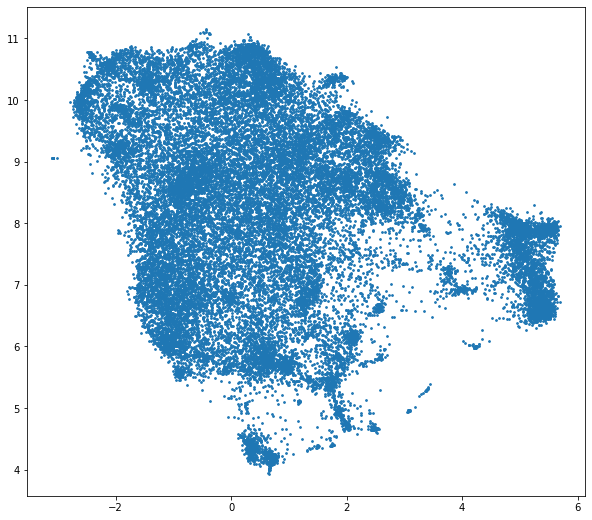

In [69]:
plt.figure(figsize=(10,9))
plt.scatter(umap_embedding[:, 0],
            umap_embedding[:, 1],
            s=3, cmap='Spectral')

Al no poder ver de cerca cual es cada palabra pierde un poco de sentido la representación. Lo que se puede hacer es representar en el grafico palabras en particular. Se propone contrastar la ubicacion de las acciones elegidas contra las tres posibles decisiones que uno puede tomar con las acciones: Comprar, Vender o Mantener.

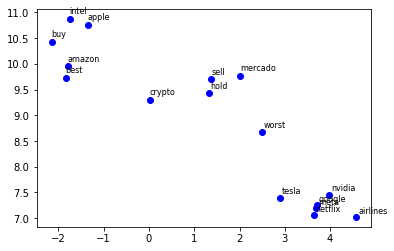

In [70]:
umap_pd = pd.DataFrame(umap_embedding, index = vocabulary,
                       columns = ["x", "y"])

pd_to_plot = umap_pd.loc[["intel", "netflix", "amazon", "apple", "tesla", "crypto", "nvidia", "meta", "google", "best", "worst", "hold", "sell", "buy", "mercado", "airlines"],:]

points = [pd_to_plot.iloc[:,0].values,
          pd_to_plot.iloc[:,1].values,
          pd_to_plot.index.values]

for i in range(len(points[0])):
    x = points[0][i]
    y = points[1][i]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01),
             points[2][i], fontsize=8)

Es interesante ver como palabras del tipo best y buy se encuentran proximas.

> ## 4) Ventana grande
Procedemos a realizar el mismo analisis con window = 8 y comparar los resultados obtenidos.

In [72]:
RETRAIN_W2VEC = False

if RETRAIN_W2VEC:

    # Defino los parámetros del modelo
    model = gensim.models.Word2Vec(vector_size=50,
                                   window=8,
                                   min_count=5,
                                   negative=5,
                                   sample=0.01,
                                   workers=4,
                                   sg=1)
    
    # Se hace una pasada por el corpus y se crea el vocabulario
    model.build_vocab(sentences,
                      progress_per=10000)
    
    # Se entrena el modelo
    model.train(sentences,
                total_examples=model.corpus_count,
                epochs=20, report_delay=1)
    
    # Se guarda en disco el modelo
    model.save("ventana_grande_w2c.model")

else:
    # Se carga el modelo entrenado
    model = gensim.models.Word2Vec.load("ventana_grande_w2c.model")

INFO - 22:39:58: loading Word2Vec object from ventana_grande_w2c.model
INFO - 22:39:58: loading wv recursively from ventana_grande_w2c.model.wv.* with mmap=None
INFO - 22:39:58: setting ignored attribute cum_table to None
INFO - 22:39:58: Word2Vec lifecycle event {'fname': 'ventana_grande_w2c.model', 'datetime': '2022-09-03T22:39:58.595316', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'loaded'}


> ### Analisis de los resultados

> Para el caso de **similitud** se sigue manteniendo el caso planteado anteriormente aunque con una diferencia menor.

In [78]:
print(model.wv.similarity("google", 'buy'))
print(model.wv.similarity("mercado", 'buy'))

0.36709774
0.3628321


In [79]:
print(model.wv.similarity("google", 'sell'))
print(model.wv.similarity("mercado", 'sell'))

0.13468419
0.27754673


> En cuanto a las **palabras similares** a cada accion se logra ver que levemente se refiere mas a los topicos de cada palabra que a la semantica. Por ejemplo, para google incluye android y apple que tiene mas sentido considerarlas en oraciones con ventanas mas amplias.

In [81]:
words = ["intel", "netflix", "amazon", "apple", "tesla", "crypto", "nvidia", "meta", "google"]
for ticker in words:
    print(ticker + " " +str(model.wv.most_similar(positive=[ticker], topn=5)))
#model.wv.most_similar(positive=["clarín"], topn=5)
#model.wv.most_similar(positive=["banco"], topn=20)
#model.wv.most_similar(positive=["incertidumbre"], topn=50)

intel [('intc.o', 0.8615646362304688), ('amd', 0.806262195110321), ('buzz-susquehanna', 0.7970610857009888), ('ryzen', 0.7563877701759338), ('celeron', 0.7524460554122925)]
netflix [('streaming', 0.7634115815162659), ('nflx', 0.7580667734146118), ('nflx.o', 0.7323524951934814), ('disney', 0.7194691300392151), ('disney+', 0.6872621178627014)]
amazon [('prime', 0.7242832183837891), ('care', 0.6498671770095825), ('inc.s', 0.6484912633895874), ('non-amazon', 0.6421166658401489), ('stillâ', 0.619242250919342)]
apple [('ipad', 0.8146990537643433), ('aapl.o', 0.7766453623771667), ('iphone', 0.7502741813659668), ('google', 0.7494588494300842), ('airpods', 0.7107922434806824)]
tesla [('tsla.o', 0.9067227840423584), ('tsla', 0.7843223214149475), ('automaker', 0.7807508111000061), ('musk', 0.7742022275924683), ('rivian', 0.754833996295929)]
crypto [('bitf.o', 0.7218067049980164), ('digi', 0.7112908363342285), ('nfts', 0.7068164944648743), ('econ', 0.6955031156539917), ('bitfarms', 0.6925409436225

> En el caso de las **analogias** en vez de suponer que nvidia sin rtx es Tesla, mejora el analisis incluyendo electric-vehicle y airlines.

La analogia con Elon Musk sigue siendo valida.

In [82]:
print(model.wv.most_similar(positive=["nvidia"], negative=["rtx"], topn=5))
print(model.wv.most_similar(positive=["nvidia", "twitter"], negative=["rtx"], topn=5))

[('tsla.o', 0.481990247964859), ('qcom.o', 0.4790419936180115), ('electric-vehicle', 0.4660416841506958), ('airlines', 0.45908457040786743), ('nvda.o', 0.436998188495636)]
[('twtr.n', 0.7552223801612854), ('musk', 0.7389690279960632), ('elon', 0.6842412948608398), ('liamwardproud', 0.656821608543396), ('ginachon', 0.6567842960357666)]


Es necesario reentrenar el u-map:

In [83]:
# Visualización con UMAP
import umap  
import matplotlib.pyplot as plt
import pandas as pd

RECALCULATE_UMAP = True

if RECALCULATE_UMAP:

    vocabulary = list(model.wv.index_to_key)
    X = model.wv.__getitem__(vocabulary)

    umap_embedding = umap.UMAP(n_neighbors=50, min_dist=0.0,
                               n_components=2, random_state=42,
                               metric='cosine').fit_transform(X)

    with open("umap_embedding_ventana_grande.p", "wb") as f:
        pickle.dump((X, vocabulary, umap_embedding), f)

else:

    with open("umap_embedding_ventana_grande.p", "rb") as f:
        X, vocabulary, umap_embedding = pickle.load(f)

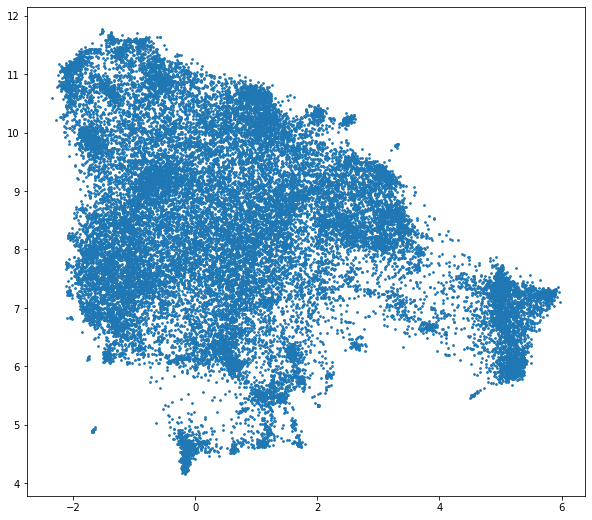

In [84]:
plt.figure(figsize=(10,9))
plt.scatter(umap_embedding[:, 0],
            umap_embedding[:, 1],
            s=3, cmap='Spectral')

El mapa obtenido es similar al anterior, con los puntos levemente mas esparcidos. Veamos como queda el graficos para las palabras analizadas anteriormente:

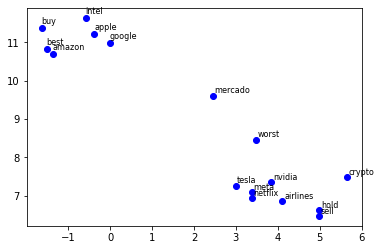

In [86]:
umap_pd = pd.DataFrame(umap_embedding, index = vocabulary,
                       columns = ["x", "y"])

pd_to_plot = umap_pd.loc[["intel", "netflix", "amazon", "apple", "tesla", "crypto", "nvidia", "meta", "google", "best", "worst", "hold", "sell", "buy", "mercado", "airlines"],:]

points = [pd_to_plot.iloc[:,0].values,
          pd_to_plot.iloc[:,1].values,
          pd_to_plot.index.values]

for i in range(len(points[0])):
    x = points[0][i]
    y = points[1][i]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01),
             points[2][i], fontsize=8)

Aumentar la ventana permite diferenciar de forma mas evidente a aquellas acciones del tipo "best" y "buy" vs aquellas mas asociadas a "sell" y "worst". Se puede concluir que aumentar la ventana tuvo un impacto positivo en cuanto al analisis de los resultados.